# ACE Exploration: Peptide Feature Similarities Exploration

### Dhuvarakesh Karthikeyan and Jin Seok (Andy) Lee

In [6]:
#Import Dependencies

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import difflib
#import Levenshtein as levenshtein
from collections import Counter

import torch
import torch.nn as nn
import mhcflurry
from transformers import BertModel, BertTokenizer

In [2]:
_PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
_PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert")

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load in the Data

In [3]:
vdjdb = pd.read_csv("vdjdb_12032022.tsv", sep='\t')
unique_cdr3s = vdjdb['CDR3'].unique()
len(unique_cdr3s)

36693

In [27]:
# Helper Function for Aggregating Data
def feature_dist(df, feature, asc=False):
    counts = dict(Counter(df[feature]))
    df = pd.DataFrame(list(counts.items()), columns = [str(feature), 'Frequency'])
    return df.sort_values(by='Frequency', ascending=asc).reset_index(drop=True)

#Helper Function for Sampling In-Group Epitopes:
def sample_ingroup(df, cdr3=None):
    if cdr3:
        try:
            return df[df['CDR3']==cdr3]
        except:
            print('CDR3 Sequence Not Found in the DataFrame')
    else:
        cdr3 = random.sample(list(df['CDR3']), 1)
        return df[df['CDR3']==cdr3[0]]

In [18]:
sorted_df = feature_dist(vdjdb, "CDR3")
target_cdr3s = list(sorted_df[sorted_df['Frequency'] > 2]['CDR3'])
target_df = vdjdb[vdjdb['CDR3'].isin(target_cdr3s)].reset_index(drop=True)

In [28]:
sample_ingroup(target_df)

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
2681,2765,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/11684"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
3579,6305,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""409/33921"", ""identification"": ""...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
3613,6358,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-A*11:01,B2M,MHCI,IVTDFSVIK,EBNA4,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
3662,6433,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""225/33921"", ""identification"": ""...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
3698,6489,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,GILGFVFTL,M,InfluenzaA,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
3893,6790,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""2/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
4054,7052,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
4149,7206,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
4328,7495,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0
4445,7733,TRB,CASSGPGGVDEQYF,TRBV5-5*01,TRBJ2-7*01,HomoSapiens,HLA-B*08:01,B2M,MHCI,RAKFKQLL,BZLF1,EBV,https://www.10xgenomics.com/resources/applicat...,"{""frequency"": ""1/33921"", ""identification"": ""de...","{""cell.subset"": """", ""clone.id"": """", ""donor.MHC...","{""cdr3"": ""CASSGPGGVDEQYF"", ""cdr3_old"": ""CASSGP...",0


### Sequence Similarity Metrics

In [54]:
 def embed(sequence, tokenizer=_PROTBERT_TOKENIZER, encoder=_PROTBERT_MODEL):
        encoded_input = tokenizer(" ".join(sequence), return_tensors='pt')
        output = encoder(**encoded_input)
        return torch.mean(output.last_hidden_state, 1).detach().numpy()[0]

def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1)*np.linalg.norm(emb2))

def dummy_embed(sequence):
    return sequence

def kmer_similarity(seq1, seq2):
    minln = len(min(seq1, seq2, key=len))
    return difflib.SequenceMatcher(None, seq1, seq2).find_longest_match().size/minln

def levenshtein_similarity(seq1, seq2):
    return levenshtein.distance(seq1, seq2)

def ratio_similarity(seq1, seq2):
    return difflib.SequenceMatcher(None, seq1, seq2).ratio()

def calc_ingroup_features(cdr3s, feature_fxn, sim_fxn):
    ingroup_sims = []
    for cdr3 in cdr3s:
        epitopes = vdjdb[vdjdb['CDR3']==cdr3]['Epitope'].unique()
        pairs = [(epi1, epi2) for idx, epi1 in enumerate(epitopes) for epi2 in epitopes[idx + 1:]]
        for pair in pairs:
            ingroup_sims += [sim_fxn(feature_fxn(pair[0]), feature_fxn(pair[1]))]
    return ingroup_sims

def sample_outgroup_tcrs(cdr3s, n):
    tcr_pairs = tcr_pairs = [(tcr1, tcr2) for idx, tcr1 in enumerate(cdr3s) for tcr2 in cdr3s[idx + 1:]]
    return random.sample(tcr_pairs, n)

def calc_outgroup_features(tcr_pairs, feature_fxn, sim_fxn):
    outgroup_sims = []
    for tcr_pair in tcr_pairs:
        epi1s = vdjdb[vdjdb['CDR3']==tcr_pair[0]]['Epitope'].unique()
        epi2s = vdjdb[vdjdb['CDR3']==tcr_pair[1]]['Epitope'].unique()
        for e1 in epi1s:
            for e2 in epi2s:
                    if e1 != e2:
                        outgroup_sims += [sim_fxn(feature_fxn(e1), feature_fxn(e2))]
    return outgroup_sims


In [49]:
outgroup_pairs = sample_outgroup_tcrs(target_df['CDR3'], 5000)

### ProtBERT Embedding Similarities

In [272]:
### Find the BERT Embedding Similarity of Epitopes that share a common TCR

ingroup_sims = calc_ingroup_features(target_df['CDR3'], embed, cosine_similarity)

In [ ]:
### Find the Similarity of Epitopes that do not share a TCR
outgroup_sims = calc_outgroup_features(outgroup_pairs, embed, cosine_similarity)

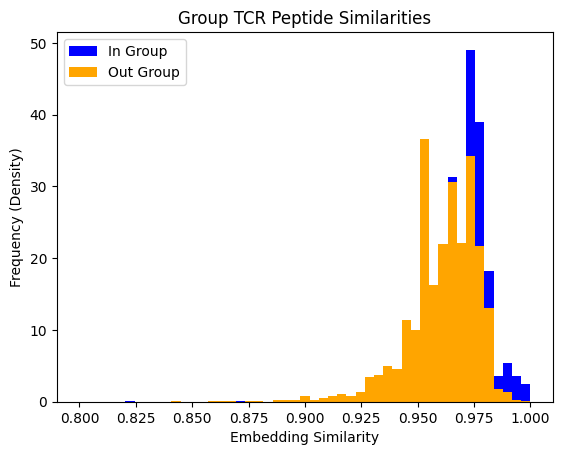

In [274]:
plt.hist(ingroup_sims,  bins=np.linspace(.8,1,50), density = True, color='blue')
plt.hist(outgroup_sims, bins=np.linspace(.8,1,50), density = True, color='orange')
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

### Levenshtein Edit Distance Similarity

In [45]:
### Find the Levenshtein Similarity of Epitopes that share a common TCR

ingroup_sims1 = calc_ingroup_features(target_df['CDR3'], dummy_embed, levenshtein_similarity)

In [46]:
outgroup_sims1 = calc_outgroup_features(target_df['CDR3'], dummy_embed, levenshtein_similarity, n=None)

KeyboardInterrupt: 

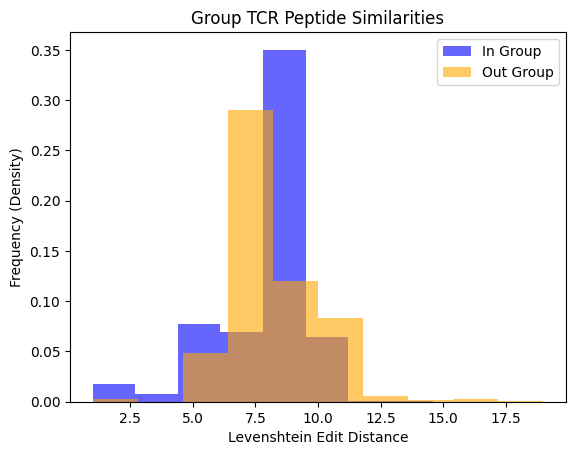

In [43]:
plt.hist(ingroup_sims1, density = True, color='blue', alpha = 0.6)
plt.hist(outgroup_sims1,  density = True, color='orange', alpha = 0.6)
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Levenshtein Edit Distance')
plt.ylabel('Frequency (Density)')
plt.show()

### Sequence K-mer Similarities

In [31]:
### Find the Kmer Similarity of Epitopes that share a common TCR

ingroup_sims2 = calc_ingroup_features(target_df['CDR3'], dummy_embed, kmer_similarity)

In [32]:
### Find the Kmer Similarity of Epitopes that DO NOT share a common TCR

outgroup_sims2 = calc_outgroup_features(target_df['CDR3'], dummy_embed, kmer_similarity)

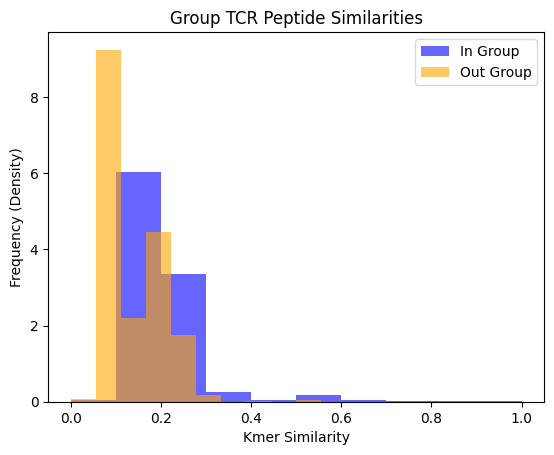

In [33]:
plt.hist(ingroup_sims2, density = True, color='blue', alpha = 0.6)
plt.hist(outgroup_sims2,  density = True, color='orange', alpha = 0.6)
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Kmer Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

### Sequence Ratio Similarity

$$ Ratio = 2*\frac{Matches}{Total}$$

In [266]:
### Find the Ratio Similarity of Epitopes that share a common TCR

ingroup_sims3 = calc_ingroup_features(target_df['CDR3'], dummy_embed, ratio_similarity)

In [267]:
### Find the Ratio Similarity of Epitopes that DO NOT share a common TCR

outgroup_sims3 = calc_outgroup_features(target_df['CDR3'], dummy_embed, ratio_similarity)

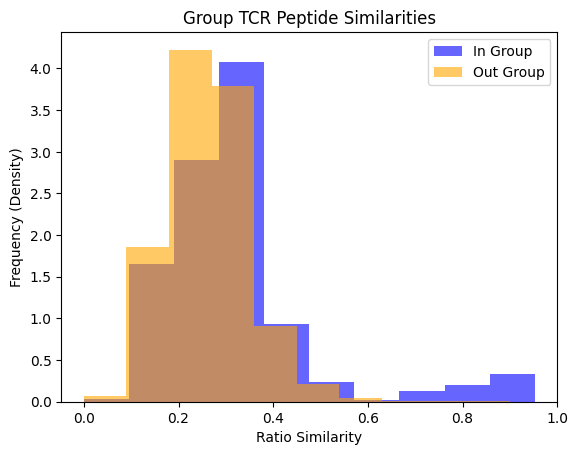

In [268]:
plt.hist(ingroup_sims3, density = True, color='blue', alpha = 0.6)
plt.hist(outgroup_sims3,  density = True, color='orange', alpha = 0.6)
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Ratio Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

### Finding Disallowed Peptides

In [98]:
def is_disallowed(pep1, idx1, pep2, idx2, feature_fxn, sim_fxn, sim_threshold):
    if sim_fxn(feature_fxn(pep1), feature_fxn(pep2)) >= sim_threshold:
        return True
    else:
        return False

In [99]:
pairs = [(idx, idx2) for idx, pep1 in enumerate(peps) for idx2, pep2 in enumerate(peps[idx + 1:]) if is_disallowed(pep1, idx, pep2, idx2, dummy_embed, ratio_similarity, 0.6)]

In [100]:
pairs

[(0, 19), (3, 19), (44, 14), (66, 30), (90, 5)]

In [58]:
def gen_vectorization(seq, mapping_table):
    return np.stack([(mapping_table.loc[s]) for s in seq])


def dataset_mapping(dset, mapping_table):
    return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])

In [57]:
aa_prop = pd.DataFrame(map(lambda x: x.split(","),
                               ("1.29,0.9,0,0.049,1.8,0,0,0.047,0.065,0.78,67,1,0,0,1;"
                                "1.11,0.74,0,0.02,2.5,-2,0,0.015,0.015,0.8,86,1,1,-1,0;"
                                "1.04,0.72,-1,0.051,-3.5,-2,1,0.071,0.074,1.41,91,1,0,1;"
                                "1.44,0.75,-1,0.051,-3.5,-2,1,0.094,0.089,1,109,1,0,1,0;"
                                "1.07,1.32,0,0.051,2.8,0,0,0.021,0.029,0.58,135,1,1,-1,0;"
                                "0.56,0.92,0,0.06,-0.4,0,0,0.071,0.07,1.64,48,1,0,1,1;"
                                "1.22,1.08,0,0.034,-3.2,1,1,0.022,0.025,0.69,118,1,0,-1,0;"
                                "0.97,1.45,0,0.047,4.5,0,0,0.032,0.035,0.51,124,1,1,-1,0;"
                                "1.23,0.77,1,0.05,-3.9,2,1,0.105,0.08,0.96,135,1,0,1,0;"
                                "1.3,1.02,0,0.078,3.8,0,0,0.052,0.063,0.59,124,1,1,-1,1;"
                                "1.47,0.97,0,0.027,1.9,0,0,0.017,0.016,0.39,124,1,1,1,0;"
                                "0.9,0.76,0,0.058,-3.5,0,1,0.062,0.053,1.28,96,1,0,1,1;"
                                "0.52,0.64,0,0.051,-1.6,0,0,0.052,0.054,1.91,90,1,0,1,0;"
                                "1.27,0.8,0,0.051,-3.5,1,1,0.053,0.051,0.97,114,1,0,1,0;"
                                "0.96,0.99,1,0.066,-4.5,2,1,0.068,0.059,0.88,148,1,0,1,1;"
                                "0.82,0.95,0,0.057,-0.8,-1,1,0.072,0.071,1.33,73,1,0,1,1;"
                                "0.82,1.21,0,0.064,-0.7,-1,0,0.064,0.065,1.03,93,1,0,0,1;"
                                "0.91,1.49,0,0.049,4.2,0,0,0.048,0.048,0.47,105,1,1,-1,0;"
                                "0.99,1.14,0,0.022,-0.9,1,1,0.007,0.012,0.75,163,1,1,-1,0;"
                                "0.72,1.25,0,0.07,-1.3,-1,1,0.032,0.033,1.05,141,1,1,-1,1").split(";")),
                           columns=['alpha', 'beta', 'charge', 'core', 'hydropathy', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'strength', 'disorder', 'high_contact', 'count'],
                           index=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

aa_prop = aa_prop.astype(float)
aa_prop

,alpha,beta,charge,core,hydropathy,pH,polarity,rim,surface,turn,volume,strength,disorder,high_contact,count
A,1.29,0.90,0.0,0.049,1.8,0.0,0.0,0.047,0.065,0.78,67.0,1.0,0.0,0.0,1.0
C,1.11,0.74,0.0,0.020,2.5,-2.0,0.0,0.015,0.015,0.80,86.0,1.0,1.0,-1.0,0.0
D,1.04,0.72,-1.0,0.051,-3.5,-2.0,1.0,0.071,0.074,1.41,91.0,1.0,0.0,1.0,NaN
E,1.44,0.75,-1.0,0.051,-3.5,-2.0,1.0,0.094,0.089,1.00,109.0,1.0,0.0,1.0,0.0
F,1.07,1.32,0.0,0.051,2.8,0.0,0.0,0.021,0.029,0.58,135.0,1.0,1.0,-1.0,0.0
G,0.56,0.92,0.0,0.060,-0.4,0.0,0.0,0.071,0.070,1.64,48.0,1.0,0.0,1.0,1.0
H,1.22,1.08,0.0,0.034,-3.2,1.0,1.0,0.022,0.025,0.69,118.0,1.0,0.0,-1.0,0.0
I,0.97,1.45,0.0,0.047,4.5,0.0,0.0,0.032,0.035,0.51,124.0,1.0,1.0,-1.0,0.0
K,1.23,0.77,1.0,0.050,-3.9,2.0,1.0,0.105,0.080,0.96,135.0,1.0,0.0,1.0,0.0
L,1.30,1.02,0.0,0.078,3.8,0.0,0.0,0.052,0.063,0.59,124.0,1.0,1.0,-1.0,1.0


In [59]:
dataset_mapping(random.sample(list(np.unique(vdjdb['Epitope'])), 100), aa_prop)

/tmp/ipykernel_1128390/3868959576.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])


array([array([[ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 5.20e-01,  6.40e-01,  0.00e+00,  5.10e-02, -1.60e+00,  0.00e+00,
                0.00e+00,  5.20e-02,  5.40e-02,  1.91e+00,  9.00e+01,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 1.27e+00,  8.00e-01,  0.00e+00,  5.10e-02, -3.50e+00,  1.00e+00,
                1.00e+00,  5.30e-02,  5.10e-02,  9.70e-01,  1.14e+02,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 1.29e+00,  9.00e-01,  0.00e+00,  4.90e-02,  1.80e+00,  0.00e+00,
                0.00e+00,  4.70e-02,  6.50e-02,  7.80e-01,  6.70e+01,  1.00

In [7]:
# Load a predictor
predictor = mhcflurry.Class1PresentationPredictor.load()

Forcing tensorflow backend.
Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
